In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import fastf1
import fastf1.logger
import numpy as np #nie masz czasu bawic sie w optymalizje
import optuna
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from telemetry_data_preprocessing import telemetry_computations

c:\Users\pat79\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fastf1.logger.set_log_level('ERROR')
fastf1.Cache.enable_cache('cache')

In [3]:
import fastf1
import pandas as pd

from telemetry_data_preprocessing import load_data, Telemetry

telemetry, X, y, baseline_df = load_data()

telemetry.head(5)

Date            SessionTime DriverAhead  \
0 2023-03-05 15:03:38.501 0 days 01:02:36.652000               
1 2023-03-05 15:03:38.611 0 days 01:02:36.762000               
2 2023-03-05 15:03:38.686 0 days 01:02:36.837000               
3 2023-03-05 15:03:38.811 0 days 01:02:36.962000               
4 2023-03-05 15:03:38.946 0 days 01:02:37.097000               

   DistanceToDriverAhead                   Time           RPM     Speed  \
0               0.155556        0 days 00:00:00  10076.374938  0.000000   
1               0.155556 0 days 00:00:00.110000  10130.000000  0.000000   
2               0.155556 0 days 00:00:00.185000   9993.499884  0.000000   
3               0.155556 0 days 00:00:00.310000   9766.000000  0.000000   
4               0.155556 0 days 00:00:00.445000   8956.001152  0.964284   

   nGear  Throttle  Brake  DRS         Source  Distance  RelativeDistance  \
0      1      16.0  False    1  interpolation  0.000194      3.748547e-08   
1      1      16.0  False    1            car  0.000000      0.000000e+00   
2      1      16.0  False    1            pos -0.000268     -5.186355e-08   
3      1      16.0  False    1            car  0.000000      0.000000e+00   
4      1      16.0  False    1            pos  0.003325      6.439951e-07   

    Status           X            Y           Z  DriverNumber  LapNumber  
0  OnTrack -279.999631  3558.983052 -156.999885             1        1.0  
1  OnTrack -279.999617  3558.982418 -156.999881             1        1.0  
2  OnTrack -280.000000  3559.000000 -157.000000             1        1.0  
3  OnTrack -280.001327  3559.060983 -157.000413             1        1.0  
4  OnTrack -280.000000  3559.000000 -157.000000             1        1.0

In [4]:
telemetry = telemetry.drop(["DriverAhead", "RPM", "Source", "Status", "RelativeDistance"], axis = 1)

In [5]:
tel = Telemetry(telemetry)

## lap progress chyba nie ma sensu bo istnieje relative distance ale to potem sprawdze eh
tel.normalize_drs()
tel.calculate_mean_lap_speed()
tel.compute_accelerations()
tel.calculate_lap_progress()
single_lap_data = tel.get_single_lap_data()

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.S

c:\Users\pat79\Desktop\nauka-studia\nauka-studia\projekty\eksploracja\F1_dataExploration\telemetry\telemetry_data_preprocessing.py:189: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, final_row], axis=0)


In [6]:
single_lap_data

Date            SessionTime  DistanceToDriverAhead  \
761    2023-03-05 15:05:17.751 0 days 01:04:15.902000               0.000278   
1499   2023-03-05 15:06:55.725 0 days 01:05:53.876000                    NaN   
2258   2023-03-05 15:10:11.707 0 days 01:09:09.858000                    NaN   
2984   2023-03-05 15:13:27.728 0 days 01:12:25.879000                    NaN   
3714   2023-03-05 15:15:05.749 0 days 01:14:03.900000                    NaN   
...                        ...                    ...                    ...   
572768 2023-03-05 15:17:13.620 0 days 01:16:11.771000              88.106389   
573511 2023-03-05 15:18:55.154 0 days 01:17:53.305000              73.670278   
574270 2023-03-05 15:20:36.738 0 days 01:19:34.889000               4.351944   
575037 2023-03-05 15:22:18.090 0 days 01:21:16.241000              68.856111   
575796 2023-03-05 15:23:59.246 0 days 01:22:57.397000               5.679722   

                         Time       Speed nGear  Throttle  Brake DRS  \
761    0 days 00:01:39.250000  280.142857     7     100.0  False   0   
1499   0 days 00:01:37.974000  280.941666     7     100.0  False   0   
2258   0 days 00:01:37.976000  280.435716     7     100.0  False   0   
2984   0 days 00:01:37.986000  281.299169     7     100.0  False   0   
3714   0 days 00:01:38.021000  280.885714     7     100.0  False   0   
...                       ...         ...   ...       ...    ...  ..   
572768 0 days 00:01:41.295000  286.574998     7      99.0  False   1   
573511 0 days 00:01:41.534000  286.749997     7      99.0  False   1   
574270 0 days 00:01:41.584000  291.429998     7      99.0  False   1   
575037 0 days 00:01:41.352000  279.468749     7      99.0  False   0   
575796 0 days 00:01:41.156000  279.720000     7      99.0  False   0   

           Distance  ...  mean_lap_speed  lon_acc  lat_acc abs_lat_acc  \
761     5141.964903  ...      185.815557  0.20226  0.58879     0.58879   
1499    5363.501061  ...      196.531157  0.23596  0.03630     0.03630   
2258    5360.387868  ...      197.711395  0.30338  0.01775     0.01775   
2984    5369.135413  ...      197.696016  0.23531  0.02310     0.02310   
3714    5369.141600  ...      197.638955  0.30338  0.03081     0.03081   
...             ...  ...             ...      ...      ...         ...   
572768  5362.128048  ...      191.880886  0.35395  0.03491     0.03491   
573511  5364.900614  ...      190.220934  0.35394 -0.25373     0.25373   
574270  5348.892812  ...      189.105442  0.28315  0.08246     0.08246   
575037  5360.722469  ...      190.452366  0.17697 -0.01613     0.01613   
575796  5368.118602  ...      190.927743  0.28316 -0.00028     0.00028   

        abs_lon_acc  sum_lat_acc  sum_lon_acc  TimeNumberLapTime  \
761         0.20226    840.76762    561.07970                762   
1499        0.23596    855.49170    515.23100                738   
2258        0.30338    853.49005    512.35496                759   
2984        0.23531    798.17038    506.39443                726   
3714        0.30338    818.31458    503.46019                730   
...             ...          ...          ...                ...   
572768      0.35395    786.42792    581.03253                785   
573511      0.35394    771.00349    535.18105                743   
574270      0.28315    765.02686    554.66969                759   
575037      0.17697    762.02163    521.07765                767   
575796      0.28316    783.92720    524.94456                759   

        TimeNumberLapCounts  LapProgress  
761                     762          1.0  
1499                    738          1.0  
2258                    759          1.0  
2984                    726          1.0  
3714                    730          1.0  
...                     ...          ...  
572768                  785          1.0  
573511                  743          1.0  
574270                  759          1.0  
575037                  767          1.0  
575796               

Obliczanie submodelu telemetrii w konteście całego okrążenia

In [7]:
single_lap_data = single_lap_data[['DriverNumber', 'mean_lap_speed', 'sum_lat_acc', 'sum_lon_acc']]

In [8]:
single_lap_data

DriverNumber  mean_lap_speed  sum_lat_acc  sum_lon_acc
761               1      185.815557    840.76762    561.07970
1499              1      196.531157    855.49170    515.23100
2258              1      197.711395    853.49005    512.35496
2984              1      197.696016    798.17038    506.39443
3714              1      197.638955    818.31458    503.46019
...             ...             ...          ...          ...
572768           81      191.880886    786.42792    581.03253
573511           81      190.220934    771.00349    535.18105
574270           81      189.105442    765.02686    554.66969
575037           81      190.452366    762.02163    521.07765
575796           81      190.927743    783.92720    524.94456

[758 rows x 4 columns]

In [9]:
X_acc = single_lap_data.copy()

In [10]:
X_acc.drop(columns='DriverNumber', inplace=True)

In [11]:
baseline_df

Time Driver DriverNumber                LapTime  \
0    0 days 01:04:15.902000    VER            1 0 days 00:01:39.019000   
1    0 days 01:05:53.876000    VER            1 0 days 00:01:37.974000   
3    0 days 01:09:09.858000    VER            1 0 days 00:01:37.976000   
5    0 days 01:12:25.879000    VER            1 0 days 00:01:37.986000   
6    0 days 01:14:03.900000    VER            1 0 days 00:01:38.021000   
...                     ...    ...          ...                    ...   
1050 0 days 01:16:11.771000    PIA           81 0 days 00:01:41.295000   
1051 0 days 01:17:53.305000    PIA           81 0 days 00:01:41.534000   
1052 0 days 01:19:34.889000    PIA           81 0 days 00:01:41.584000   
1053 0 days 01:21:16.241000    PIA           81 0 days 00:01:41.352000   
1054 0 days 01:22:57.397000    PIA           81 0 days 00:01:41.156000   

      LapNumber  Stint PitOutTime PitInTime            Sector1Time  \
0           1.0    1.0        NaT       NaT                    NaT   
1           2.0    1.0        NaT       NaT 0 days 00:00:31.342000   
3           4.0    1.0        NaT       NaT 0 days 00:00:31.271000   
5           6.0    1.0        NaT       NaT 0 days 00:00:31.341000   
6           7.0    1.0        NaT       NaT 0 days 00:00:31.290000   
...         ...    ...        ...       ...                    ...   
1050        8.0    1.0        NaT       NaT 0 days 00:00:31.665000   
1051        9.0    1.0        NaT       NaT 0 days 00:00:31.989000   
1052       10.0    1.0        NaT       NaT 0 days 00:00:31.779000   
1053       11.0    1.0        NaT       NaT 0 days 00:00:31.894000   
1054       12.0    1.0        NaT       NaT 0 days 00:00:32.100000   

                Sector2Time  ...             Team           LapStartTime  \
0    0 days 00:00:42.414000  ...  Red Bull Racing 0 days 01:02:36.652000   
1    0 days 00:00:42.504000  ...  Red Bull Racing 0 days 01:04:15.902000   
3    0 days 00:00:42.642000  ...  Red Bull Racing 0 days 01:07:31.882000   
5    0 days 00:00:42.632000  ...  Red Bull Racing 0 days 01:10:47.893000   
6    0 days 00:00:42.763000  ...  Red Bull Racing 0 days 01:12:25.879000   
...                     ...  ...              ...                    ...   
1050 0 days 00:00:44.590000  ...          McLaren 0 days 01:14:30.476000   
1051 0 days 00:00:44.548000  ...          McLaren 0 days 01:16:11.771000   
1052 0 days 00:00:44.617000  ...          McLaren 0 days 01:17:53.305000   
1053 0 days 00:00:44.557000  ...          McLaren 0 days 01:19:34.889000   
1054 0 days 00:00:44.235000  ...          McLaren 0 days 01:21:16.241000   

                LapStartDate TrackStatus  Position  Deleted  DeletedReason  \
0    2023-03-05 15:03:38.501          12       1.0    False                  
1    2023-03-05 15:05:17.751          12       1.0    False                  
3    2023-03-05 15:08:33.731           1       1.0    False                  
5    2023-03-05 15:11:49.742           1       1.0    False                  
6    2023-03-05 15:13:27.728           1       1.0    False                  
...                      ...         ...       ...      ...            ...   
1050 2023-03-05 15:15:32.325           1      16.0    False                  
1051 2023-03-05 15:17:13.620           1      16.0    False                  
1052 2023-03-05 15:18:55.154           1      16.0    False                  
1053 2023-03-05 15:20:36.738           1      13.0    False                  
1054 2023-03-05 15:22:18.090           1      11.0    False                  

      FastF1Generated IsAccurate LapTime_sec  
0               False      False      99.019  
1               False       True      97.974  
3               False       True      97.976  
5               False       True      97.986  
6               False       True      98.021  
...               ...        ...         ...  
1050            False       True     101.295  
1051            False       True     101.534  
1052            Fals

In [12]:
X = baseline_df[['LapNumber', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'DriverNumber','Compound', 'TyreLife', 'Stint', 'Team']]

In [13]:
le = LabelEncoder()
X['Compound'] = le.fit_transform(X['Compound'])
le.classes_

C:\Users\pat79\AppData\Local\Temp\ipykernel_15120\1998924212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Compound'] = le.fit_transform(X['Compound'])


array(['HARD', 'MEDIUM', 'SOFT'], dtype=object)

In [14]:
le = LabelEncoder()
X['Team'] = le.fit_transform(X['Team'])
le.classes_

C:\Users\pat79\AppData\Local\Temp\ipykernel_15120\2069166165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Team'] = le.fit_transform(X['Team'])


array(['Alfa Romeo', 'AlphaTauri', 'Alpine', 'Aston Martin', 'Ferrari',
       'Haas F1 Team', 'McLaren', 'Mercedes', 'Red Bull Racing',
       'Williams'], dtype=object)

In [15]:
X_acc

mean_lap_speed  sum_lat_acc  sum_lon_acc
761         185.815557    840.76762    561.07970
1499        196.531157    855.49170    515.23100
2258        197.711395    853.49005    512.35496
2984        197.696016    798.17038    506.39443
3714        197.638955    818.31458    503.46019
...                ...          ...          ...
572768      191.880886    786.42792    581.03253
573511      190.220934    771.00349    535.18105
574270      189.105442    765.02686    554.66969
575037      190.452366    762.02163    521.07765
575796      190.927743    783.92720    524.94456

[758 rows x 3 columns]

In [16]:
X_acc.reset_index(inplace=True)

In [17]:
X.reset_index(inplace=True)

In [18]:
X_c = pd.concat([X, X_acc], axis=1)

In [19]:
X_c

index  LapNumber  SpeedI1  SpeedI2  SpeedFL DriverNumber  Compound  \
0        0        1.0    232.0    231.0    278.0            1         2   
1        1        2.0    227.0    238.0    278.0            1         2   
2        3        4.0    228.0    238.0    278.0            1         2   
3        5        6.0    229.0    239.0    279.0            1         2   
4        6        7.0    230.0    239.0    279.0            1         2   
..     ...        ...      ...      ...      ...          ...       ...   
753   1050        8.0    225.0    230.0    283.0           81         2   
754   1051        9.0    223.0    230.0    283.0           81         2   
755   1052       10.0    225.0    245.0    288.0           81         2   
756   1053       11.0    222.0    240.0    277.0           81         2   
757   1054       12.0    224.0    243.0    276.0           81         2   

     TyreLife  Stint  Team   index  mean_lap_speed  sum_lat_acc  sum_lon_acc  
0         4.0    1.0     8     761      185.815557    840.76762    561.07970  
1         5.0    1.0     8    1499      196.531157    855.49170    515.23100  
2         7.0    1.0     8    2258      197.711395    853.49005    512.35496  
3         9.0    1.0     8    2984      197.696016    798.17038    506.39443  
4        10.0    1.0     8    3714      197.638955    818.31458    503.46019  
..        ...    ...   ...     ...             ...          ...          ...  
753       8.0    1.0     6  572768      191.880886    786.42792    581.03253  
754       9.0    1.0     6  573511      190.220934    771.00349    535.18105  
755      10.0    1.0     6  574270      189.105442    765.02686    554.66969  
756      11.0    1.0     6  575037      190.452366    762.02163    521.07765  
757      12.0    1.0     6  575796      190.927743    783.92720    524.94456  

[758 rows x 14 columns]

In [20]:
X['mean_lap_speed'] = X_c['mean_lap_speed']

C:\Users\pat79\AppData\Local\Temp\ipykernel_15120\3913793289.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['mean_lap_speed'] = X_c['mean_lap_speed']


In [21]:
X_c

index  LapNumber  SpeedI1  SpeedI2  SpeedFL DriverNumber  Compound  \
0        0        1.0    232.0    231.0    278.0            1         2   
1        1        2.0    227.0    238.0    278.0            1         2   
2        3        4.0    228.0    238.0    278.0            1         2   
3        5        6.0    229.0    239.0    279.0            1         2   
4        6        7.0    230.0    239.0    279.0            1         2   
..     ...        ...      ...      ...      ...          ...       ...   
753   1050        8.0    225.0    230.0    283.0           81         2   
754   1051        9.0    223.0    230.0    283.0           81         2   
755   1052       10.0    225.0    245.0    288.0           81         2   
756   1053       11.0    222.0    240.0    277.0           81         2   
757   1054       12.0    224.0    243.0    276.0           81         2   

     TyreLife  Stint  Team   index  mean_lap_speed  sum_lat_acc  sum_lon_acc  
0         4.0    1.0     8     761      185.815557    840.76762    561.07970  
1         5.0    1.0     8    1499      196.531157    855.49170    515.23100  
2         7.0    1.0     8    2258      197.711395    853.49005    512.35496  
3         9.0    1.0     8    2984      197.696016    798.17038    506.39443  
4        10.0    1.0     8    3714      197.638955    818.31458    503.46019  
..        ...    ...   ...     ...             ...          ...          ...  
753       8.0    1.0     6  572768      191.880886    786.42792    581.03253  
754       9.0    1.0     6  573511      190.220934    771.00349    535.18105  
755      10.0    1.0     6  574270      189.105442    765.02686    554.66969  
756      11.0    1.0     6  575037      190.452366    762.02163    521.07765  
757      12.0    1.0     6  575796      190.927743    783.92720    524.94456  

[758 rows x 14 columns]

In [22]:
X_c.drop(columns='index', inplace=True)
X.drop(columns='index', inplace=True)

C:\Users\pat79\AppData\Local\Temp\ipykernel_15120\4108384375.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns='index', inplace=True)


In [23]:
X_c

LapNumber  SpeedI1  SpeedI2  SpeedFL DriverNumber  Compound  TyreLife  \
0          1.0    232.0    231.0    278.0            1         2       4.0   
1          2.0    227.0    238.0    278.0            1         2       5.0   
2          4.0    228.0    238.0    278.0            1         2       7.0   
3          6.0    229.0    239.0    279.0            1         2       9.0   
4          7.0    230.0    239.0    279.0            1         2      10.0   
..         ...      ...      ...      ...          ...       ...       ...   
753        8.0    225.0    230.0    283.0           81         2       8.0   
754        9.0    223.0    230.0    283.0           81         2       9.0   
755       10.0    225.0    245.0    288.0           81         2      10.0   
756       11.0    222.0    240.0    277.0           81         2      11.0   
757       12.0    224.0    243.0    276.0           81         2      12.0   

     Stint  Team  mean_lap_speed  sum_lat_acc  sum_lon_acc  
0      1.0     8      185.815557    840.76762    561.07970  
1      1.0     8      196.531157    855.49170    515.23100  
2      1.0     8      197.711395    853.49005    512.35496  
3      1.0     8      197.696016    798.17038    506.39443  
4      1.0     8      197.638955    818.31458    503.46019  
..     ...   ...             ...          ...          ...  
753    1.0     6      191.880886    786.42792    581.03253  
754    1.0     6      190.220934    771.00349    535.18105  
755    1.0     6      189.105442    765.02686    554.66969  
756    1.0     6      190.452366    762.02163    521.07765  
757    1.0     6      190.927743    783.92720    524.94456  

[758 rows x 12 columns]

In [24]:
X

LapNumber  SpeedI1  SpeedI2  SpeedFL DriverNumber  Compound  TyreLife  \
0          1.0    232.0    231.0    278.0            1         2       4.0   
1          2.0    227.0    238.0    278.0            1         2       5.0   
2          4.0    228.0    238.0    278.0            1         2       7.0   
3          6.0    229.0    239.0    279.0            1         2       9.0   
4          7.0    230.0    239.0    279.0            1         2      10.0   
..         ...      ...      ...      ...          ...       ...       ...   
753        8.0    225.0    230.0    283.0           81         2       8.0   
754        9.0    223.0    230.0    283.0           81         2       9.0   
755       10.0    225.0    245.0    288.0           81         2      10.0   
756       11.0    222.0    240.0    277.0           81         2      11.0   
757       12.0    224.0    243.0    276.0           81         2      12.0   

     Stint  Team  mean_lap_speed  
0      1.0     8      185.815557  
1      1.0     8      196.531157  
2      1.0     8      197.711395  
3      1.0     8      197.696016  
4      1.0     8      197.638955  
..     ...   ...             ...  
753    1.0     6      191.880886  
754    1.0     6      190.220934  
755    1.0     6      189.105442  
756    1.0     6      190.452366  
757    1.0     6      190.927743  

[758 rows x 10 columns]

In [25]:
y

0        99.019
1        97.974
3        97.976
5        97.986
6        98.021
         ...   
1050    101.295
1051    101.534
1052    101.584
1053    101.352
1054    101.156
Name: LapTime_sec, Length: 758, dtype: float64

In [26]:
assert X_c.shape[0] == y.shape[0]

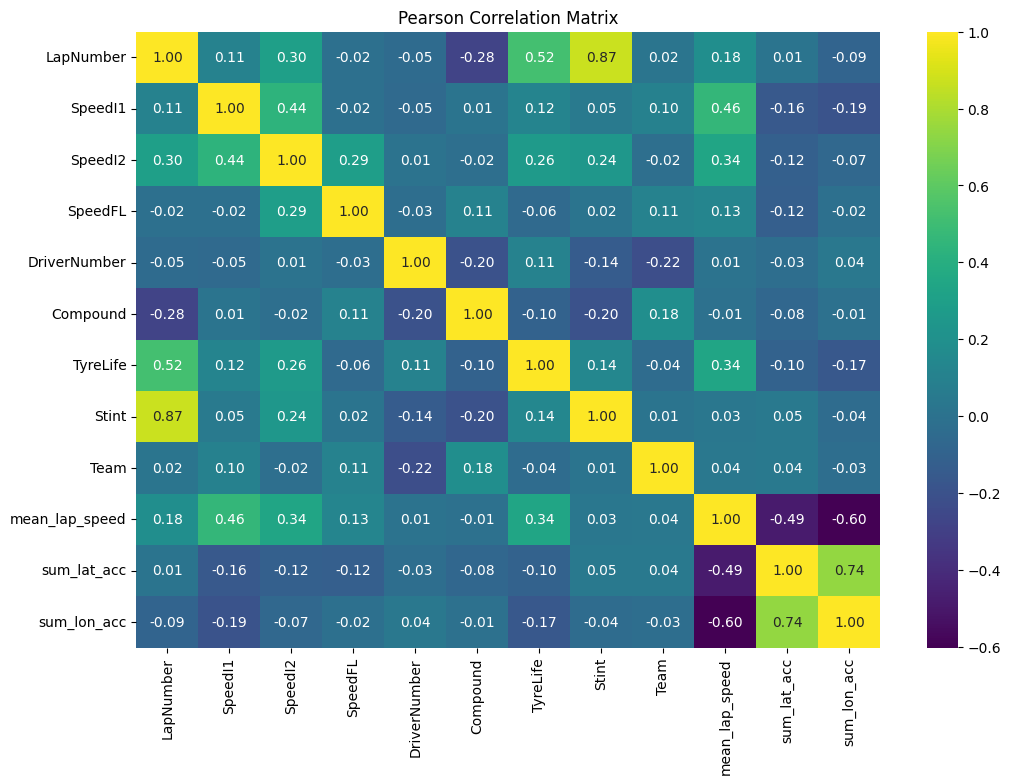

In [27]:
plt.figure(figsize=(12,8))

corr = X_c.corr()

sns.heatmap(corr, annot=True, cmap='viridis', fmt=".2f")

plt.title("Pearson Correlation Matrix")

plt.show()

In [28]:
X_scaled = StandardScaler().fit_transform(X)
X_scaled_c = StandardScaler().fit_transform(X_c)

# Split once, using indices
X_train_idx, X_test_idx = train_test_split(range(len(y)), test_size=0.2, random_state=42)

# Apply the split to both versions of X
X_train = X_scaled[X_train_idx]
X_test = X_scaled[X_test_idx]

X_train_c = X_scaled_c[X_train_idx]
X_test_c = X_scaled_c[X_test_idx]

y_train = y.iloc[X_train_idx]
y_test = y.iloc[X_test_idx]

Linear Regression

In [29]:
# Model 1
model1 = LinearRegression()
model1.fit(X_train, y_train)
y_pred_1 = model1.predict(X_test)
mse_1 = mean_squared_error(y_test, y_pred_1)

# Model 2
model2 = LinearRegression()
model2.fit(X_train_c, y_train)
y_pred_2 = model2.predict(X_test_c)
mse_2 = mean_squared_error(y_test, y_pred_2)

print(f"Model 1 MSE (original features): {mse_1:.3f}")
print(f"Model 2 MSE (new features): {mse_2:.3f}")

Model 1 MSE (original features): 0.894
Model 2 MSE (new features): 0.868


In [30]:
print("Model 1 coefficients:", model1.coef_)
print("Model 2 coefficients:", model2.coef_)

Model 1 coefficients: [ 0.16767569 -0.04236916 -0.09204951  0.01530636 -0.02594719 -0.21123731
 -0.10435759  0.27644781  0.01589156 -6.81125343]
Model 2 coefficients: [ 1.32648220e-01 -4.48636537e-02 -8.52537166e-02  2.62407554e-02
 -2.01395977e-02 -1.98674042e-01 -9.80470428e-02  2.92172138e-01
  1.80539487e-03 -6.75861316e+00  1.97464151e-01 -7.32657481e-02]


In [31]:
from sklearn.model_selection import cross_val_score

scores1 = cross_val_score(LinearRegression(), X_scaled, y, scoring='neg_mean_squared_error', cv=5)
scores2 = cross_val_score(LinearRegression(), X_scaled_c, y, scoring='neg_mean_squared_error', cv=5)

print(f"Model 1 CV MSE: {-scores1.mean():.3f}")
print(f"Model 2 CV MSE: {-scores2.mean():.3f}")

Model 1 CV MSE: 1.062
Model 2 CV MSE: 1.055


Decision Tree


In [32]:
tree_model = DecisionTreeRegressor(random_state=12)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mse_tree = mean_squared_error(y_test, y_pred_tree)
print(f"Decision Tree MSE: {mse_tree:.3f}")

tree_model = DecisionTreeRegressor(random_state=12)
tree_model.fit(X_train_c, y_train)
y_pred_tree_c = tree_model.predict(X_test_c)
mse_tree = mean_squared_error(y_test, y_pred_tree_c)
print(f"Decision Tree MSE with additional data: {mse_tree:.3f}")

Decision Tree MSE: 0.566
Decision Tree MSE with additional data: 0.568


In [33]:
from functools import partial

def objective(trial, X_train, y_train, X_test, y_test):
    max_depth = trial.suggest_int('max_depth', 2, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    tree = DecisionTreeRegressor(
        random_state=12,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    return mse

objective_with_data = partial(objective, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

print("\nOptimizing Decision Tree with Optuna...")
study = optuna.create_study(direction="minimize", storage="sqlite:///db.sqlite3", )
study.optimize(objective_with_data, n_trials=30)

print("Best parameters:", study.best_params)
print(f"Best Decision Tree MSE: {study.best_value:.3f}")

objective_with_data = partial(objective, X_train=X_train_c, y_train=y_train, X_test=X_test_c, y_test=y_test)

print("\nOptimizing Decision Tree with Optuna...")
study = optuna.create_study(direction="minimize", storage="sqlite:///db.sqlite3", )
study.optimize(objective_with_data, n_trials=30)

print("Best parameters with additional data:", study.best_params)
print(f"Best Decision Tree MSE with additional data: {study.best_value:.3f}")


Optimizing Decision Tree with Optuna...


[I 2025-06-05 00:16:58,348] A new study created in RDB with name: no-name-930d0b13-ce4a-4506-a7e3-af6136b38486
[I 2025-06-05 00:16:58,444] Trial 0 finished with value: 0.8794969431451183 and parameters: {'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8794969431451183.
[I 2025-06-05 00:16:58,522] Trial 1 finished with value: 0.9610035253331585 and parameters: {'max_depth': 13, 'min_samples_split': 19, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8794969431451183.
[I 2025-06-05 00:16:58,584] Trial 2 finished with value: 2.352742075460364 and parameters: {'max_depth': 2, 'min_samples_split': 18, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8794969431451183.
[I 2025-06-05 00:16:58,647] Trial 3 finished with value: 0.44624858416459506 and parameters: {'max_depth': 9, 'min_samples_split': 16, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.44624858416459506.
[I 2025-06-05 00:16:58,713] Trial 4 finished with value: 0.4461

Best parameters: {'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 6}
Best Decision Tree MSE: 0.392

Optimizing Decision Tree with Optuna...


[I 2025-06-05 00:17:01,068] Trial 2 finished with value: 0.9059287883547464 and parameters: {'max_depth': 7, 'min_samples_split': 4, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.3951918802392632.
[I 2025-06-05 00:17:01,137] Trial 3 finished with value: 0.4772613031477213 and parameters: {'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.3951918802392632.
[I 2025-06-05 00:17:01,203] Trial 4 finished with value: 0.7959727026460622 and parameters: {'max_depth': 8, 'min_samples_split': 18, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.3951918802392632.
[I 2025-06-05 00:17:01,270] Trial 5 finished with value: 0.44850431511164573 and parameters: {'max_depth': 10, 'min_samples_split': 15, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.3951918802392632.
[I 2025-06-05 00:17:01,336] Trial 6 finished with value: 0.42638927281046696 and parameters: {'max_depth': 8, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 

Best parameters with additional data: {'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 5}
Best Decision Tree MSE with additional data: 0.395


DTW

In [34]:
session = fastf1.get_session(2023, 'Bahrain', 'Q')
session.load(telemetry=True)

In [35]:
q_lap = session.laps.pick_driver('VER').pick_fastest().get_telemetry()
q_lap['DriverNumber'] = 1.0
q_lap['LapNumber'] = 1.0

c:\Users\pat79\AppData\Local\Programs\Python\Python313\Lib\site-packages\fastf1\core.py:3067: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


In [36]:
q_lap = Telemetry(q_lap)

q_lap.compute_accelerations()
q_lap.data

<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


Date            SessionTime DriverAhead  \
2   2023-03-04 16:07:25.761 0 days 01:22:24.764000               
3   2023-03-04 16:07:25.858 0 days 01:22:24.861000               
4   2023-03-04 16:07:26.056 0 days 01:22:25.059000               
5   2023-03-04 16:07:26.058 0 days 01:22:25.061000               
6   2023-03-04 16:07:26.377 0 days 01:22:25.380000          31   
..                      ...                    ...         ...   
651 2023-03-04 16:08:54.977 0 days 01:23:53.980000          31   
652 2023-03-04 16:08:55.177 0 days 01:23:54.180000          31   
653 2023-03-04 16:08:55.318 0 days 01:23:54.321000          31   
654 2023-03-04 16:08:55.456 0 days 01:23:54.459000          31   
655 2023-03-04 16:08:55.469 0 days 01:23:54.472000          31   

     DistanceToDriverAhead                   Time           RPM       Speed  \
2              1396.081389        0 days 00:00:00  10664.421894  292.312499   
3              1396.081389 0 days 00:00:00.097000  10635.018789  293.524998   
4              1396.081389 0 days 00:00:00.295000  10575.000000  296.000000   
5              1396.081389 0 days 00:00:00.297000  10575.747616  296.012460   
6              1396.081389 0 days 00:00:00.616000  10695.000000  298.000000   
..                     ...                    ...           ...         ...   
651            1006.834444 0 days 00:01:29.216000  11373.000000  288.000000   
652             998.390000 0 days 00:01:29.416000  11478.000000  290.000000   
653             992.279993 0 days 00:01:29.557000  11521.462415  291.516131   
654             986.300000 0 days 00:01:29.695000  11564.000000  293.000000   
655             986.300000 0 days 00:01:29.708000  11568.333312  293.108333   

     nGear  Throttle  Brake  ...            Y           Z  DriverNumber  \
2        7     100.0  False  ...  1265.072445 -159.000000           1.0   
3        7     100.0  False  ...  1366.000000 -159.000000           1.0   
4        8     100.0  False  ...  1642.602047 -159.000000           1.0   
5        8     100.0  False  ...  1645.000000 -159.000000           1.0   
6        8     100.0  False  ...  1842.825184 -158.999979           1.0   
..     ...       ...    ...  ...          ...         ...           ...   
651      7     100.0  False  ...   997.158260 -159.017311           1.0   
652      7     100.0  False  ...  1145.962906 -159.070513           1.0   
653      7     100.0  False  ...  1251.000000 -159.000000           1.0   
654      7     100.0  False  ...  1366.035348 -158.813518           1.0   
655      7     100.0  False  ...  1377.501115 -158.789948           1.0   

     LapNumber  lon_acc  lat_acc  abs_lat_acc  abs_lon_acc  sum_lat_acc  \
2          1.0  0.35217  0.11610      0.11610      0.35217     865.4447   
3          1.0  0.17642  0.07690      0.07690      0.17642     865.4447   
4          1.0  0.21506  0.03091      0.03091      0.21506     865.4447   
5          1.0  0.28316  0.04167      0.04167      0.28316     865.4447   
6          1.0  0.28316  0.10456      0.10456      0.28316     865.4447   
..         ...      ...      ...          ...          ...          ...   
651        1.0  0.30447 -0.03713      0.03713      0.30447     865.4447   
652        1.0  0.29857 -0.06347      0.06347      0.29857     865.4447   
653        1.0  0.23596 -0.32912      0.32912      0.23596     865.4447   
654        1.0      NaN      NaN          NaN          NaN     865.4447   
655        1.0      NaN      NaN          NaN          NaN     865.4447   

     sum_lon_acc  
2      525.38095  
3      525.38095  
4      525.38095  
5      525.38095  
6      525.38095  
..           ...  
651    525.38095  
652    525.38095  
653    525.38095  
654    525.38095  
655    525.38095  

[654 rows x 26 columns]

In [37]:
test_df = tel.data.copy()

In [38]:
test_lap = test_df[(test_df['DriverNumber'] == 1) & (test_df['LapNumber'] == 2.0) ]

In [41]:
from tslearn.metrics import dtw

distance = dtw(q_lap.data['lat_acc'], test_lap['lat_acc'])
distance

17.690048810339665

In [48]:
test_df = test_df[test_df['DriverNumber'] == 1]

In [61]:
laps = test_df['LapNumber'].unique()

In [63]:
ref_signal = q_lap.data['lat_acc']

results = []
for lap in laps:
    signal = test_df[test_df['LapNumber'] == float(lap)]['lat_acc']
    distance = dtw(signal, ref_signal)
    results.append({"lap": lap, "dtw_distance": distance})

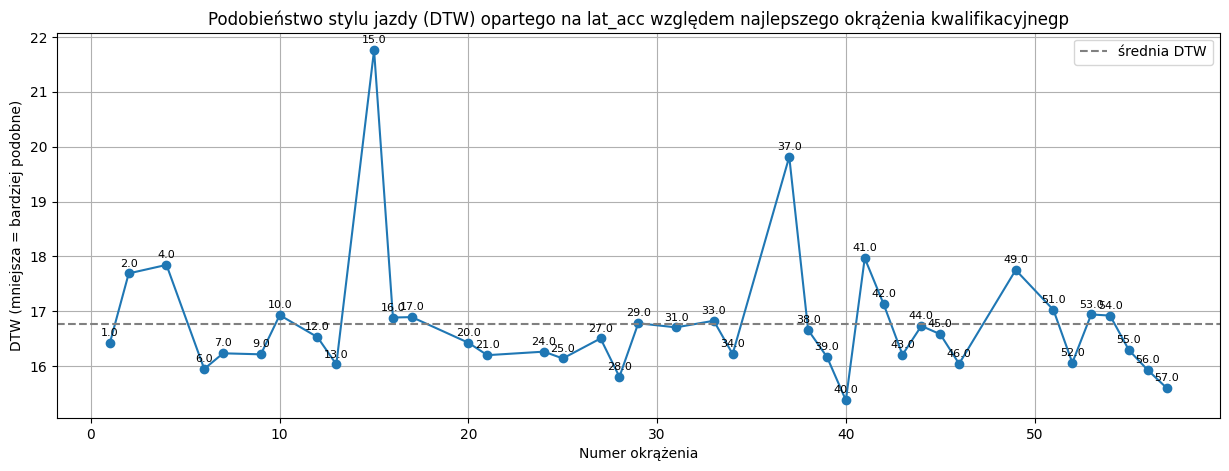

In [71]:
results_df = pd.DataFrame(results)
plt.figure(figsize=(15, 5))
plt.plot(results_df["lap"], results_df["dtw_distance"], marker="o")

for _, row in results_df.iterrows():
    plt.annotate(str(row["lap"]), (row["lap"], row["dtw_distance"]), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

plt.axhline(results_df["dtw_distance"].mean(), color="gray", linestyle="--", label="średnia DTW")
plt.title(f"Podobieństwo stylu jazdy (DTW) opartego na lat_acc względem najlepszego okrążenia kwalifikacyjnegp")
plt.xlabel("Numer okrążenia")
plt.ylabel("DTW (mniejsza = bardziej podobne)")
plt.legend()
plt.grid(True)
plt.show()

## trzeba oznaczyc pity albo je wyjebac

In [75]:
baseline_df[(baseline_df['LapNumber'] == 15) & (baseline_df['Driver'] == 'VER')]

Time Driver DriverNumber                LapTime  \
14 0 days 01:27:33.930000    VER            1 0 days 00:01:58.378000   

    LapNumber  Stint             PitOutTime PitInTime            Sector1Time  \
14       15.0    2.0 0 days 01:25:58.127000       NaT 0 days 00:00:51.854000   

              Sector2Time  ...             Team           LapStartTime  \
14 0 days 00:00:42.629000  ...  Red Bull Racing 0 days 01:25:35.552000   

              LapStartDate TrackStatus  Position  Deleted  DeletedReason  \
14 2023-03-05 15:26:37.401           1       2.0    False                  

    FastF1Generated IsAccurate LapTime_sec  
14            False      False     118.378  

[1 rows x 32 columns]

In [78]:
baseline_df[(baseline_df['LapNumber'] == 37) & (baseline_df['Driver'] == 'VER')]

Time Driver DriverNumber                LapTime  \
36 0 days 02:03:45.820000    VER            1 0 days 00:01:58.490000   

    LapNumber  Stint             PitOutTime PitInTime            Sector1Time  \
36       37.0    3.0 0 days 02:02:10.556000       NaT 0 days 00:00:52.755000   

              Sector2Time  ...             Team           LapStartTime  \
36 0 days 00:00:42.071000  ...  Red Bull Racing 0 days 02:01:47.330000   

              LapStartDate TrackStatus  Position  Deleted  DeletedReason  \
36 2023-03-05 16:02:49.179           1       1.0    False                  

    FastF1Generated IsAccurate LapTime_sec  
36            False      False      118.49  

[1 rows x 32 columns]

In [40]:
from sktime.transformations.panel.rocket import MiniRocket
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# X: np.array shape (n_samples, n_channels, series_length)

## to na potem, ja nie wiem co sie tu dzieje nawet

rocket = MiniRocket()
X_feat = rocket.fit_transform(X_test_c)  # shape: (n_samples, n_features)

# Klasteryzacja
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_feat)

# Wizualizacja
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_feat)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis')
plt.title("Okrążenia zgrupowane na podstawie stylu jazdy")
plt.show()


KeyboardInterrupt: 